# Maximum likelihood method to estimate $p_0$ and migration rate $m$

In [1]:
library(tidyverse)

Loading tidyverse: ggplot2
Loading tidyverse: tibble
Loading tidyverse: tidyr
Loading tidyverse: readr
Loading tidyverse: purrr
Loading tidyverse: dplyr
Conflicts with tidy packages ---------------------------------------------------
filter(): dplyr, stats
lag():    dplyr, stats


### Function simulating the trajectories of a Nea. alleles given $s$, $h$ and $p_0$

It can simulate deterministic selection (no drift) on a single or multiple loci, or drift.

In [2]:
simulate_migration <- function(p0, m, total_time) {
    p_trajectory <- c(p0, rep(0, total_time - 1))

    for (gen in seq_len(total_time)[-1]) {
        p_trajectory[gen] <- p_trajectory[gen - 1] * (1 - m)
    }

    p_trajectory
}

## Example of the ML procedure on simulated data

#### Function to approximate noisy aDNA samples

Given a vector of times in generations and a simulated trajectory of Nea. ancestry proportions calculated using `simulate_selection` function we sample individual datapoints (aDNA individuals) at each specified time point (in generations after admixture).

The way it works is that we take the simulated Nea. trajectory at each time as a parameter $p$ in the binomial distribution, and sample from this binomial distribution `snp_count` SNPs and calculate the mean Nea. ancestry from these SNPs. This introduces a little bit of noise, approximating the noisy aDNA data we have.

In [3]:
sample_datapoints <- function(sample_times, traj, snp_count) {
    data.frame(
        nea=sapply(sample_times,
                   function(gen) {
                       mean(rbinom(snp_count, 1, traj[gen])) 
                   }),
        snp_count=snp_count,
        gen=sample_times
    )
}

Simulation of the trajectory of Nea. ancestry (given $p_0$ and $m$) and sampling "aDNA samples" from this trajectory. We can see that the noisiness of the simulated data corresponds quite well to what we see in the real data.

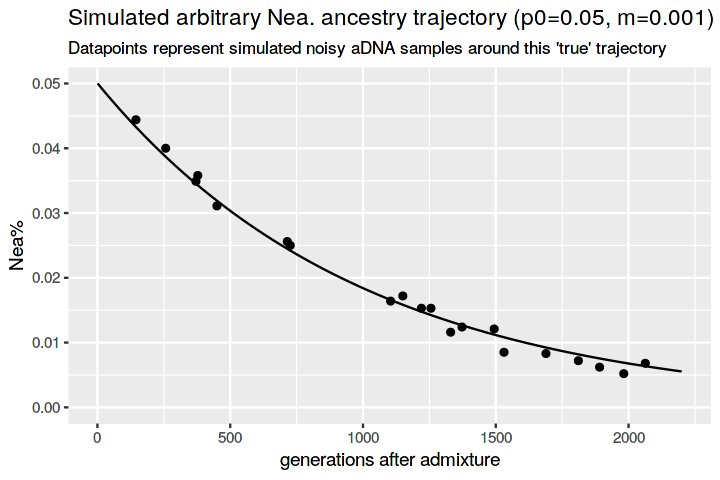

In [4]:
total_time <- 2200 # generations
sample_times <- sort(sample(1:2200, 20)) # ages of the 20 aDNA samples

p0 <- 0.05   # initial Nea. frequency
m <- 0.001   # migration rate

# simulate the dilution of Nea. alleles with
traj <- simulate_migration(p0, m, total_time)

# sample aDNA samples
aDNA_samples <- sample_datapoints(sample_times, traj, snp_count=10000)

options(repr.plot.width=6, repr.plot.height=4)

# plot the simulated trajectory of Nea. ancestry together with
# the simulated "aDNA samples"
qplot(1:total_time, traj, geom="line", ylab="Nea%", xlab="generations after admixture", ylim=c(0, 0.05)) +
    geom_point(aes(gen, nea), data=aDNA_samples) +
    ggtitle(label=paste0("Simulated arbitrary Nea. ancestry trajectory (p0=", p0, ", m=", m, ")"),
            subtitle="Datapoints represent simulated noisy aDNA samples around this 'true' trajectory")

## Maximum likelihood method to fit $m$ and $p_0$ from the simulated data

We assume admixture 55 kya.

The idea is to find the set of parameters that maximize the likelihood of aDNA samples given the Nea. trajectory determined by these parameters.

### Negative log-likelihood function of the parameters $s$ and $p_0$ given aDNA data

The likelihood of each aDNA Neanderthal ancestry estimate is calculated as if it was drawn from a binomial distribution, with a parameter $p$ representing a Nea. ancestry value at a given time. Likelihoods of all samples are then combined together to generate a combined negative log-likelihood.

The number of SNPs available for each sample is taken into account during the binomial likelihood calculation (less SNPs available means higher tolerance for deviation from the Nea. ancestry value predicted by $p_0$ and $s$ in each iteration).

In [5]:
negLL <- function(param, real_data) {
    # parameters of the model
    p0 <- param[1] # initial Nea. ancestry
    m <- param[2]  # migration rate
    
    # simulate the Nea. ancestry trajectory determined by the parameters
    # and subset to the values corresponding to time points of the aDNA
    # samples
    sim_data <- as.vector(simulate_migration(p0,
                                             m,
                                             total_time=2200)[real_data$gen])
    
    # calculate the negative log-likelihoods of each individual aDNA point
    # (the number of Nea-like SNPs observed on all SNPs available for the sample)
    # given the parameters (actually, given the Nea. trajectory determined
    # by the parameters)
    -sum(dbinom(as.integer(real_data$nea * real_data$snp_count),
                real_data$snp_count,
                sim_data, log=TRUE))
}

In [6]:
# minimize the negative log-likelihood function
# start from arbitrary initial Nea 10% and s=-0.1
results <- optim(c(0.5, 0.1), negLL, real_data=aDNA_samples)

Warning message in dbinom(as.integer(real_data$nea * real_data$snp_count), real_data$snp_count, :
"NaNs produced"Warning message in dbinom(as.integer(real_data$nea * real_data$snp_count), real_data$snp_count, :
"NaNs produced"Warning message in dbinom(as.integer(real_data$nea * real_data$snp_count), real_data$snp_count, :
"NaNs produced"Warning message in dbinom(as.integer(real_data$nea * real_data$snp_count), real_data$snp_count, :
"NaNs produced"Warning message in dbinom(as.integer(real_data$nea * real_data$snp_count), real_data$snp_count, :
"NaNs produced"Warning message in dbinom(as.integer(real_data$nea * real_data$snp_count), real_data$snp_count, :
"NaNs produced"Warning message in dbinom(as.integer(real_data$nea * real_data$snp_count), real_data$snp_count, :
"NaNs produced"Warning message in dbinom(as.integer(real_data$nea * real_data$snp_count), real_data$snp_count, :
"NaNs produced"Warning message in dbinom(as.integer(real_data$nea * real_data$snp_count), real_data$snp_count, 

**MLE values** of the $p_0$ and $m$:

In [7]:
(mle_p0 <- results$par[1])
(mle_m <- results$par[2])

[1] 0.05272906

[1] 0.001064989

**Original values** of the $p_0$ and $m$ for comparison:

In [8]:
p0
m

[1] 0.05

[1] 0.001

Yay! It works! The ML method was able to recover the true parameters $m$ and $p_0$ used for  simulating the data quite accurately.

Now we can use the same ML optimization method to estimate $m$ and $p_0$ in the real aDNA data.

## Maximum likelihood estimation of $m$ and $p_0$ using the real aDNA data

In [9]:
estimates <- read_tsv("../output/nea_estimates.txt") %>% mutate(gen=as.integer((55000 - age) / 25))

Parsed with column specification:
cols(
  name = col_character(),
  nea = col_double(),
  age = col_integer(),
  snp_count = col_integer()
)


In [10]:
head(estimates)

name,nea,age,snp_count,gen
UstIshim,0.02834072,45020,479930,399
Kostenki14,0.02656486,37470,400947,701
GoyetQ116_1,0.02880845,34795,97356,808
Muierii2,0.02226141,33300,14154,868
Vestonice13,0.02894517,30870,23091,965
Vestonice16,0.02552449,30010,172180,999


In [11]:
results <- optim(c(0.1, 0.01), negLL, real_data=estimates)

Warning message in dbinom(as.integer(real_data$nea * real_data$snp_count), real_data$snp_count, :
"NaNs produced"Warning message in dbinom(as.integer(real_data$nea * real_data$snp_count), real_data$snp_count, :
"NaNs produced"Warning message in dbinom(as.integer(real_data$nea * real_data$snp_count), real_data$snp_count, :
"NaNs produced"

**MLE values** of the $p_0$ and $s$:

In [12]:
(mle_p0 <- results$par[1])
(mle_m <- results$par[2])

[1] 0.03131205

[1] 0.0002305255

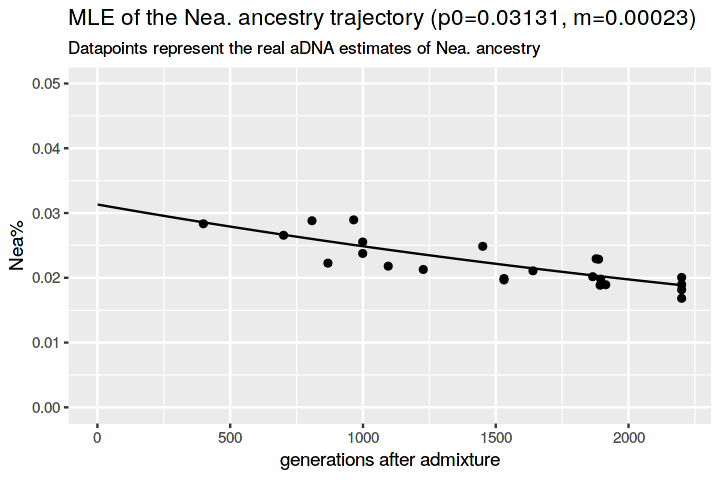

In [13]:
options(repr.plot.width=6, repr.plot.height=4)

total_time <- 2200 # generations

# simulate the selection against Nea. alleles using the MLE of parameters
mle_traj <- simulate_migration(mle_p0, mle_m, total_time)

# plot the simulated trajectory of Nea. ancestry together with
# the simulated "aDNA samples"
qplot(1:total_time, mle_traj, geom="line", ylab="Nea%", xlab="generations after admixture", ylim=c(0, 0.05)) +
    geom_point(aes(gen, nea), data=estimates) +
    ggtitle(label=paste0("MLE of the Nea. ancestry trajectory (",
                         "p0=", round(mle_p0, digits=5), ", ",
                         "m=", round(mle_m, digits=5), ")"),
            subtitle="Datapoints represent the real aDNA estimates of Nea. ancestry")